Algorithm A4 and A6:

1.Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment (DM and DM-sen)

2.Handling Conditional Discrimination (LM and LPS)

Reference: https://ieeexplore.ieee.org/document/6137304

In [34]:
import warnings
warnings.filterwarnings('ignore')

## Data Processing

In [35]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
# full_data = pd.read_csv('../data/compas-scores-two-years.csv')
full_data = pd.read_csv('/content/drive/MyDrive/ADS-hw4/data/compas-scores-two-years.csv')
full_data = pd.DataFrame(full_data)

### Prepare data

In [39]:
data = full_data.copy()
# Include only required two races
data = data[(data['race']=='African-American')|(data['race']=='Caucasian')]
data.isna().sum().sort_values(ascending=False)

violent_recid              6150
vr_charge_degree           5433
vr_case_number             5433
vr_offense_date            5433
vr_charge_desc             5433
c_arrest_date              5165
r_jail_out                 4087
r_jail_in                  4087
r_days_from_arrest         4087
r_charge_desc              3141
r_offense_date             3089
r_case_number              3089
r_charge_degree            3089
c_offense_date              999
c_jail_out                  235
days_b_screening_arrest     235
c_jail_in                   235
out_custody                 180
in_custody                  180
c_charge_desc                21
c_days_from_compas           14
c_case_number                14
v_type_of_assessment          0
type_of_assessment            0
decile_score.1                0
v_decile_score                0
v_score_text                  0
v_screening_date              0
screening_date                0
priors_count.1                0
start                         0
end     

In [40]:
data.drop(['violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
         'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc',
         'r_offense_date','r_case_number','r_charge_degree'], axis=1,inplace=True)

In [41]:
data.race.unique()

array(['African-American', 'Caucasian'], dtype=object)

In [42]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6150 entries, 1 to 7212
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       6150 non-null   int64  
 1   name                     6150 non-null   object 
 2   first                    6150 non-null   object 
 3   last                     6150 non-null   object 
 4   compas_screening_date    6150 non-null   object 
 5   sex                      6150 non-null   object 
 6   dob                      6150 non-null   object 
 7   age                      6150 non-null   int64  
 8   age_cat                  6150 non-null   object 
 9   race                     6150 non-null   object 
 10  juv_fel_count            6150 non-null   int64  
 11  decile_score             6150 non-null   int64  
 12  juv_misd_count           6150 non-null   int64  
 13  juv_other_count          6150 non-null   int64  
 14  priors_count            

### Construct each variable

In [44]:
categorical_features = ['id','first','last','age_cat','race','c_charge_degree','c_charge_desc','type_of_assessment',
                        'score_text','v_type_of_assessment','v_score_text']

In [45]:
X = data.copy() # an instance in p dimensional space
selected_column= X[categorical_features]
categorical_df = selected_column.copy()

In [46]:
categorical_df

,id,first,last,age_cat,race,c_charge_degree,c_charge_desc,type_of_assessment,score_text,v_type_of_assessment,v_score_text
1,3,kevon,dixon,25 - 45,African-American,F,Felony Battery w/Prior Convict,Risk of Recidivism,Low,Risk of Violence,Low
2,4,ed,philo,Less than 25,African-American,F,Possession of Cocaine,Risk of Recidivism,Low,Risk of Violence,Low
3,5,marcu,brown,Less than 25,African-American,F,Possession of Cannabis,Risk of Recidivism,High,Risk of Violence,Medium
6,8,edward,riddle,25 - 45,Caucasian,F,Possession Burglary Tools,Risk of Recidivism,Medium,Risk of Violence,Low
8,10,elizabeth,thieme,25 - 45,Caucasian,M,Battery,Risk of Recidivism,Low,Risk of Violence,Low
...,...,...,...,...,...,...,...,...,...,...,...
7207,10994,jarred,payne,25 - 45,African-American,M,Possess Cannabis/20 Grams Or Less,Risk of Recidivism,Low,Risk of Violence,Low
7208,10995,raheem,smith,Less than 25,African-American,F,Possession of Cocaine,Risk of Recidivism,High,Risk of Violence,High
7209,10996,steven,butler,Less than 25,African-American,F,Deliver Cannabis,Risk of Recidivism,Medium,Risk of Violence,Medium
7210,10997,malcolm,simmons,Less than 25,African-American,F,Leaving the Scene of Accident,Risk of Recidivism,Low,Risk of Violence,Medium


In [47]:
corr = categorical_df.corr()

In [48]:
X = data.copy() # an instance in p dimensional space
selected_column= X[categorical_features]

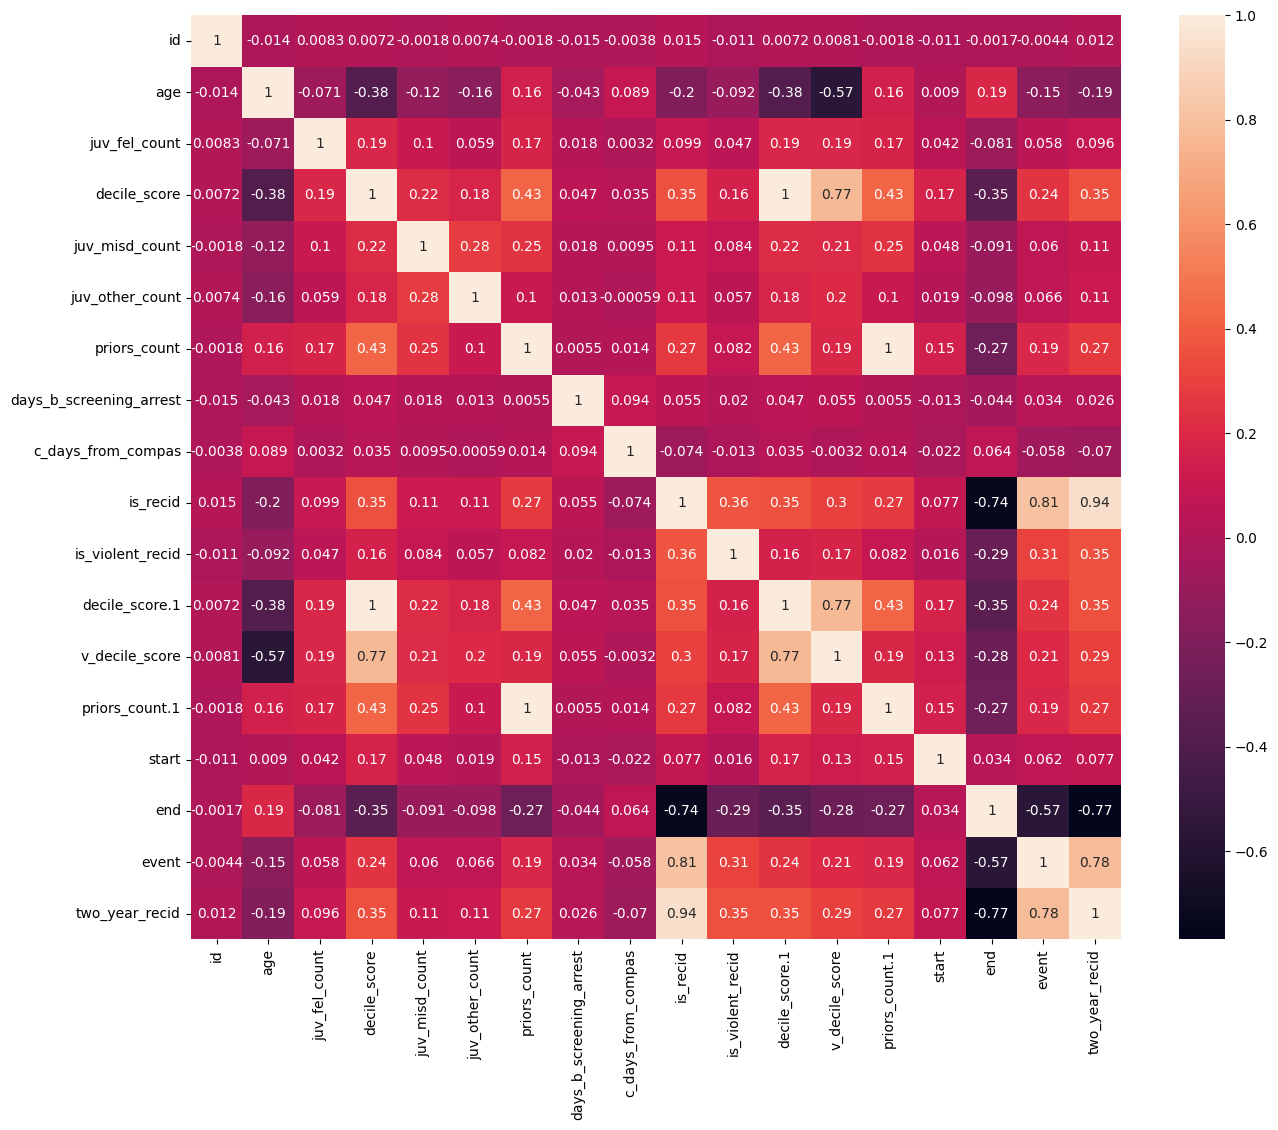

In [49]:
# categorical_correlation= associations(categorical_df, filename= 'categorical_correlation.png', figsize=(10,10))

import seaborn as sns
corr = X.corr()
fig,ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr, annot=True)
plt.show()

In [50]:
e_list = ['first', 'last', 'sex','age','race','priors_count','juv_fel_count','decile_score']
exclude_e_s = ['compas_screening_date',
               'age',
               'age_cat',
               'juv_misd_count',
               'juv_other_count',
               'priors_count',
               'days_b_screening_arrest',
               'c_jail_in',
               'c_jail_out',
               'c_offense_date',
               'c_days_from_compas',
               'is_recid',
               'is_violent_recid',
               'type_of_assessment',
               'decile_score.1',
               'screening_date',
               'v_type_of_assessment',
               'v_decile_score',
               'v_screening_date',
               'in_custody',
               'out_custody',
               'priors_count.1',
               'start',
               'end',
               'event']

In [51]:
X = data # an instance in p dimensional space
new_X = data[exclude_e_s]

s = data[['race']] # sensitive attribute

e = data[e_list] # explanatory attribute 

y = data[['two_year_recid']] # label: if a particular person will re-offend in the next two years

In [52]:
print(X.shape)

(6150, 40)


### Prep - subroutine PARTITION (Algorithm 3)

In [53]:
def partition(X,e):
    e_list = list(e.keys())
    X_i = []
    for i in range(len(e_list)):
        X[e_list[i]] = e[e_list[i]]
        X_i.append(X)
    return X_i

In [54]:
temp = partition(new_X,e)

In [55]:
temp[0].shape

(6150, 31)

Local Massaging (LM) algorithm and Local Preferential Sampling (LPS) algorithm have different approaches for handling the sensitive attribute.

LM considers the sensitive attribute as a binary classification problem; LPS divides the sensitive attribute into two groups.

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV

### Baseline Model

In [58]:
# df = pd.read_csv('../data/compas-scores-two-years.csv')
df = pd.read_csv('/content/drive/MyDrive/ADS-hw4/data/compas-scores-two-years.csv')
df.columns[df.isna().any()==False]

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree',
       'is_recid', 'is_violent_recid', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date', 'v_type_of_assessment',
       'v_decile_score', 'v_score_text', 'v_screening_date', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [59]:
selected_features = ['first', 'last', 'sex','age','race','priors_count','juv_fel_count','decile_score','two_year_recid']

In [60]:
df_cleaned = df[selected_features][(df['race']=='Caucasian') | (df['race']=='African-American')].copy()
df_cleaned.head()
df_cleaned.index = np.arange(0,len(df_cleaned))
df_cleaned

,first,last,sex,age,race,priors_count,juv_fel_count,decile_score,two_year_recid
0,kevon,dixon,Male,34,African-American,0,0,3,1
1,ed,philo,Male,24,African-American,4,0,4,1
2,marcu,brown,Male,23,African-American,1,0,8,0
3,edward,riddle,Male,41,Caucasian,14,0,6,1
4,elizabeth,thieme,Female,39,Caucasian,0,0,1,0
...,...,...,...,...,...,...,...,...,...
6145,jarred,payne,Male,30,African-American,0,0,2,1
6146,raheem,smith,Male,20,African-American,0,0,9,0
6147,steven,butler,Male,23,African-American,0,0,7,0
6148,malcolm,simmons,Male,23,African-American,0,0,3,0


In [61]:
numerical = ['priors_count']
enc = OneHotEncoder(drop='if_binary',sparse=False)
X_1 = enc.fit_transform(df_cleaned.drop(['two_year_recid'],axis=1))
X_1 = np.hstack((X_1,df_cleaned[numerical].to_numpy()))
y_1 = df_cleaned['two_year_recid'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.15, random_state=0)

In [62]:
enc = OneHotEncoder(handle_unknown='ignore')
X_new = enc.fit(X_1)
X_new = enc.transform(X_1)
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.3, random_state=44)

In [63]:
clf = RandomForestClassifier(random_state=44)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=44)

In [64]:
y_pred_test = clf.predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

0.6720867208672087
[[737 238]
 [367 503]]


In [65]:
confusion_matrix = confusion_matrix(y_test, y_pred_test)
tp = confusion_matrix[1, 1]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]
import numpy as np

def calculate_f1_recall(tp, fp, fn ):
    # Calculate the precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    # Calculate the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score, recall


In [66]:
calculate_f1_recall(tp, fp, fn )

(0.6244568590937306, 0.5781609195402299)

In [67]:
cali_X = X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']

print("Caliberation of African American and Caucasian:", np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

Caliberation of African American and Caucasian: 0.029932885906040263


###A6-Algorithm 1: Local Massaging (LM)

In [68]:
X = data # an instance in p dimensional space
new_X = data[exclude_e_s]

s = data[['race']] # sensitive attribute

e = data[e_list] # explanatory attribute 

y = data[['two_year_recid']] # label: if a particular person will re-offend in the next two years

#### DELTA for LM

In [69]:
def delta(item, y_pred, y_prob):
    
    item_copy = item.copy()
    item_copy['label'] = y_pred
    af = item_copy[item_copy.race=='African-American']
    ca = item_copy[item_copy.race =='Caucasian']
    rate_af = round(af[af['label']==1].shape[0]/af.shape[0],2)
    rate_ca = round(ca[ca['label']==1].shape[0]/ca.shape[0],2)
    p_star = (rate_af+rate_ca)/2
    threshold = np.abs(rate_af-p_star)
    
    test_df = pd.DataFrame(y_prob, columns=['No', 'Yes'], index=item.index)
    test_df['race'] = item['race']
    test_df['label'] = y_pred
    race = 'African-American'
    if (test_df['race'] == race).any():
        G_i = (test_df['race'] == race).sum()
        temp = test_df[(np.abs(test_df.Yes - test_df.No) <= G_i*threshold)].copy()
        temp.loc[(temp.race == race) & (temp.Yes > temp.No), 'label'] = 0
    race = 'Caucasian'
    if (test_df['race'] == race).any():
        G_i = 13
        temp = test_df[(np.abs(test_df.Yes - test_df.No) <= G_i*threshold)].copy()
        temp.loc[(temp.race == race) & (temp.Yes < temp.No), 'label'] = 1
    
    item_copy['label'].loc[temp.index] = temp.label
    
    return item_copy


#### Local Massaging

In [70]:
def local_massaging(X,s,e,y):
    X['race'] = s
    X_i_list =partition(X,e)
    df_list = []
    pd_list = []
    for item in X_i_list:
        enc = OneHotEncoder(handle_unknown='ignore')
        X_new = enc.fit(item)
        X_new = enc.transform(item)
        X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=.3,random_state=5)
        logreg = RandomForestClassifier(random_state=44).fit(X_train, y_train)
        y_pred = logreg.predict(X_new)
        y_prob = logreg.predict_proba(X_new)
        temp_df = delta(item,y_pred,y_prob)
        pd_list.append(temp_df)
        df_list.append(temp_df[['label']])
    result = pd.concat(df_list,axis = 1)
    result.loc[result.sum(axis=1)<=2,'new_label'] = 0
    result.loc[result.sum(axis=1)>=3,'new_label'] = 1
    X['new_label'] = result.new_label
    return X


In [71]:
New_X = local_massaging(new_X,s,e,y)

In [72]:
af = New_X[New_X.race=='African-American']
ca = New_X[New_X.race =='Caucasian']
rate_af = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)

In [73]:
rate_af,rate_ca 

(0.52, 0.44)

In [74]:
New_y = New_X.new_label
New_X_copy = New_X.copy()
New_X_copy.drop(['new_label'],axis=1,inplace=True)

In [75]:
# enc = OneHotEncoder(handle_unknown='ignore')

enc =OneHotEncoder(drop='if_binary',sparse=False)

In [76]:
X_new = enc.fit(New_X_copy)
X_new = enc.transform(New_X_copy)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_new,New_y,test_size=.3,random_state=42)

In [78]:
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) 

In [79]:
y_pred_test = forest.predict(X_test)

In [80]:
accuracy_score(y_test, y_pred_test)

0.964769647696477

In [ ]:
# confusion_matrix(y_test, y_pred_test)

In [81]:
confusion_matrix =np.array([[894,  41],
                            [ 24, 886]])

In [82]:
tp = confusion_matrix[1, 1]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]
calculate_f1_recall(tp, fp, fn )

(0.9646162221012521, 0.9736263736263736)

Caliberation of African American and Caucasian

In [83]:
cali_X = New_X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test

af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']

print("Caliberation of African American and Caucasian:", np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

Caliberation of African American and Caucasian: 0.01559110130538699


### A6-Algorithm 2: Local Preferential Sampling (LPS)

#### DELTA for LPS

In [84]:
def delta_lps(item, y_pred, y_prob):
    item_copy = item.copy()
    item_copy['label'] = y_pred
    af = item_copy[item_copy.race == 'African-American']
    ca = item_copy[item_copy.race == 'Caucasian']
    rate_af = round(af[af['label'] == 1].shape[0]/af.shape[0], 2) # two-year recid rate of African-American
    rate_ca = round(ca[ca['label'] == 1].shape[0]/ca.shape[0], 2) # two-year recid rate of Caucasian
    p_star = (rate_af + rate_ca)/2 # Equation 4
    threshold = np.abs(rate_af - p_star)
    
    test_df = pd.DataFrame(y_prob, columns=['No', 'Yes'], index=item.index)
    test_df['race'] = item['race']
    test_df['label'] = y_pred
    
    race = 'African-American'
    if (test_df['race'] == race).any():
        G_i = (test_df['race'] == race).sum()
        temp = test_df.copy()
        temp = temp[temp['race'] == race]

        # Delete 1/2 African-American + that are the closest to the threshold
        temp_del = temp.copy()
        temp_del['distance'] = np.abs(temp_del['Yes'] - temp_del['No'] - threshold)
        temp_del = temp_del.sort_values('distance', ascending=True)
        temp_del = temp_del.iloc[G_i // 2:]
        temp_del.loc[(temp_del.race == race) & (temp_del.Yes < temp_del.No), 'label'] = 0
        item_copy['label'].loc[temp_del.index] = temp_del.label

        # Duplicate 1/2 African-American − that are the closest to the threshold
        temp_dup = temp.copy()
        temp_dup['distance'] = np.abs(temp_dup['Yes'] - temp_dup['No'] + threshold)
        temp_dup = temp_dup.sort_values('distance', ascending=True)
        temp_dup = temp_dup.iloc[:G_i // 2]
        temp_dup.loc[(temp_dup.race == race) & (temp_dup.Yes > temp_dup.No), 'label'] = 1
        item_copy['label'].loc[temp_dup.index] = temp_dup.label
    
    race = 'Caucasian'
    if (test_df['race'] == race).any():
        G_i = (test_df['race'] == race).sum()
        temp = test_df.copy()
        temp = temp[temp['race'] == race]

        # Delete 1/2 Caucasian + that are the closest to the threshold
        temp_del = temp.copy()
        temp_del['distance'] = np.abs(temp_del['Yes'] - temp_del['No'] + threshold)
        temp_del = temp_del.sort_values('distance', ascending=True)
        temp_del = temp_del.iloc[G_i // 2:]
        temp_del.loc[(temp_del.race == race) & (temp_del.Yes > temp_del.No), 'label'] = 0
        item_copy['label'].loc[temp_del.index] = temp_del.label

        # Duplicate 1/2 Caucasian − that are the closest to the threshold
        temp_dup = temp.copy()
        temp_dup['distance'] = np.abs(temp_dup['Yes'] - temp_dup['No'] - threshold)
        temp_dup = temp_dup.sort_values('distance', ascending=True)
        temp_dup = temp_dup.iloc[:G_i // 2]
        temp_dup.loc[(temp_dup.race == race) & (temp_dup.Yes < temp_dup.No), 'label'] = 1
        item_copy['label'].loc[temp_dup.index] = temp_dup.label
    
    return item_copy


#### Local Preferential Sampling

In [85]:
def local_preferential_sampling(X,s,e,y):
    X['race'] = s
    X_i_list = partition(X,e)
    df_list = []
    pd_list = []
    for item in X_i_list:
        enc = OneHotEncoder(handle_unknown='ignore')
        X_new = enc.fit(item)
        X_new = enc.transform(item)
        X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=.3,random_state=5)
        forest = RandomForestClassifier(random_state=44).fit(X_train, y_train) 
        y_pred = forest.predict(X_new)
        y_prob = forest.predict_proba(X_new)
        temp_df = delta_lps(item,y_pred,y_prob)
        pd_list.append(temp_df)
        df_list.append(temp_df[['label']])
    
    result = pd.concat(df_list,axis = 1)
    result.loc[result.sum(axis=1)<=2,'new_label'] = 0
    result.loc[result.sum(axis=1)>=3,'new_label'] = 1
    X['new_label'] = result.new_label
    return X

In [86]:
New_X = local_preferential_sampling(new_X, s, e, y)

In [87]:
af = New_X[New_X.race=='African-American']
ca = New_X[New_X.race =='Caucasian']
rate_af = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)

rate_af,rate_ca 

(0.52, 0.5)

In [88]:
enc = OneHotEncoder(handle_unknown='ignore')

New_y = New_X.new_label
New_X_copy = New_X.copy()
New_X_copy.drop(['new_label'],axis=1,inplace=True)

X_new = enc.fit_transform(New_X_copy)

X_train, X_test, y_train, y_test = train_test_split(X_new, New_y, test_size=0.3,random_state=42)
forest = RandomForestClassifier(random_state=44).fit(X_train, y_train)
y_pred_test = forest.predict(X_test)

In [89]:
accuracy_score(y_test, y_pred_test)

0.9669376693766938

In [ ]:
# confusion_matrix(y_test, y_pred_test)

In [90]:
confusion_matrix = np.array([[881,  20],
                             [ 41, 903]])

In [91]:
tp = confusion_matrix[1, 1]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]
calculate_f1_recall(tp, fp, fn )

(0.967327262988752, 0.9565677966101694)

In [92]:
cali_X = New_X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test

af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']

np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred))
print("Caliberation of African American and Caucasian:", np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

Caliberation of African American and Caucasian: 0.03776429490715205


## Perform A4 (DM and DM-Sen)

### A4-Disparate Mistreatment And Disparate Mistreatment (DM & DM-Sen)

In [93]:
#downloading dccp package

!wget https://files.pythonhosted.org/packages/source/d/dccp/dccp-1.0.4.tar.gz
!tar -xf dccp-1.0.4.tar.gz
%cd dccp-1.0.4/
!sed -i 's/use_2to3=True,//g' setup.py
!python setup.py install
!pip install utils

--2023-04-12 21:14:10--  https://files.pythonhosted.org/packages/source/d/dccp/dccp-1.0.4.tar.gz
Resolving files.pythonhosted.org (files.pythonhosted.org)... 151.101.1.63, 151.101.65.63, 151.101.129.63, ...
Connecting to files.pythonhosted.org (files.pythonhosted.org)|151.101.1.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://files.pythonhosted.org/packages/b8/99/c0baff4de0ba858b2a2c8caab887afa123ddbd4cdec9187bbd4c1ae5d28e/dccp-1.0.4.tar.gz [following]
--2023-04-12 21:14:10--  https://files.pythonhosted.org/packages/b8/99/c0baff4de0ba858b2a2c8caab887afa123ddbd4cdec9187bbd4c1ae5d28e/dccp-1.0.4.tar.gz
Reusing existing connection to files.pythonhosted.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 8025 (7.8K) [application/x-tar]
Saving to: ‘dccp-1.0.4.tar.gz’

dccp-1.0.4.tar.gz   100%[===================>]   7.84K  --.-KB/s    in 0s      

2023-04-12 21:14:10 (62.5 MB/s) - ‘dccp-1.0.4.tar.gz’ saved [8025/8025]

/content/dccp-1.0.4/

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import dccp
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
import cvxpy
import sys
import os
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

In [95]:
def data_preprocessing(df, features, cate_features, cont_features, sensitive_feature, predicted_feature):
    df = df.dropna(subset=cont_features)
    df = df.loc[:, features + [predicted_feature]]
    df = df.loc[(df.race=="African-American")|(df.race=="Caucasian")]
    df.reset_index(drop=True,inplace=True)
    
    data = {}
    for k in df.keys():
      data[k] = np.array(df[k].tolist())
    
    y = data[predicted_feature]
    y[y == 0] = -1
    z=0
    
    X = np.array([]).reshape(len(y), 0)
    X_cate = np.array([]).reshape(len(y), 0)

    for feature in cate_features:
      value = data[feature]
      lb = LabelBinarizer()
      value = lb.fit_transform(value)
      X_cate = np.hstack((X_cate, value))
    
    X = np.hstack((X, X_cate))
    X_cont = np.array([]).reshape(len(y), 0)
    for feature in cont_features:
      value = data[feature]
      value = [float(v) for v in value]
      value = scale(value)
      value = np.reshape(value, (len(y), -1))
      X_cont = np.hstack((X_cont, value))

    X = np.hstack((X, X_cont))
    X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

    v = data[sensitive_feature]
    lb.fit(v)
    v = lb.transform(v)
    z = np.array(v).flatten()


    return X, y, z


In [96]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, scale, LabelBinarizer

In [97]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

features = ["age", "race", "sex", "priors_count", "c_charge_degree","score_text"]
cate_features = ["sex", "c_charge_degree", "score_text"]
cont_features = ["age", "priors_count"]
predicted_feature = "two_year_recid"
sensitive_feature = "race"

X,y,x_race = data_preprocessing(df, features, cate_features, cont_features, sensitive_feature, predicted_feature)
z          = np.array(x_race).reshape(-1, 1)
X_sen      = np.append(X, z, axis=1)

X_train,     X_test,     y_train,     y_test,     x_race_train,     x_race_test     = train_test_split(X,    y,x_race,test_size=0.2,random_state=5243)
X_train_sen, X_test_sen, y_train_sen, y_test_sen, x_race_train_sen, x_race_test_sen = train_test_split(X_sen,y,x_race,test_size=0.2,random_state=5243)

print(X.shape, y.shape, x_race.shape)

(6150, 8) (6150,) (6150,)


In [98]:
def get_constraint_list_cov(x_train, y_train, x_control_train, sensitive_attrs_to_cov_thresh, cons_type, w):

    """
    get the list of constraints to be fed to the minimizer
    cons_type == 0: means the whole combined misclassification constraint (without FNR or FPR)
    cons_type == 1: FPR constraint
    cons_type == 2: FNR constraint
    cons_type == 4: both FPR as well as FNR constraints
    sensitive_attrs_to_cov_thresh: is a dict like {s: {cov_type: val}}
    s is the sensitive attr
    cov_type is the covariance type. contains the covariance for all misclassifications, FPR and for FNR etc
    """

    constraints = []

    attr_arr = x_control_train
    attr_arr_transformed, index_dict = get_one_hot_encoding(attr_arr)
            
    if index_dict is None: # binary attribute, in this case, the attr_arr_transformed is the same as the attr_arr

        s_val_to_total = {ct:{} for ct in [0,1,2]} # constrain type -> sens_attr_val -> total number
        s_val_to_avg = {ct:{} for ct in [0,1,2]}
        cons_sum_dict = {ct:{} for ct in [0,1,2]} # sum of entities (females and males) in constraints are stored here

        for v in set(attr_arr):
            s_val_to_total[0][v] = sum(x_control_train == v)
            s_val_to_total[1][v] = sum(np.logical_and(x_control_train == v, y_train == -1)) # FPR constraint so we only consider the ground truth negative dataset for computing the covariance
            s_val_to_total[2][v] = sum(np.logical_and(x_control_train == v, y_train == +1))


        for ct in [0,1,2]:
            s_val_to_avg[ct][0] = s_val_to_total[ct][1] / float(s_val_to_total[ct][0] + s_val_to_total[ct][1]) # N1/N in our formulation, differs from one constraint type to another
            s_val_to_avg[ct][1] = 1.0 - s_val_to_avg[ct][0] # N0/N

        
        for v in set(attr_arr):

            idx = x_control_train == v                

            dist_bound_prod = cvxpy.multiply(y_train[idx], x_train[idx] * w) # y.f(x)
            
            cons_sum_dict[0][v] = cvxpy.sum( cvxpy.minimum(0, dist_bound_prod) ) * (s_val_to_avg[0][v] / len(x_train)) # avg misclassification distance from boundary
            cons_sum_dict[1][v] = cvxpy.sum( cvxpy.minimum(0, cvxpy.multiply( (1 - y_train[idx])/2.0, dist_bound_prod) ) ) * (s_val_to_avg[1][v] / sum(y_train == -1)) # avg false positive distance from boundary (only operates on the ground truth neg dataset)
            cons_sum_dict[2][v] = cvxpy.sum( cvxpy.minimum(0, cvxpy.multiply( (1 + y_train[idx])/2.0, dist_bound_prod) ) ) * (s_val_to_avg[2][v] / sum(y_train == +1)) # avg false negative distance from boundary

            
        if cons_type == 4:
            cts = [1,2]
        elif cons_type in [0,1,2]:
            cts = [cons_type]
        
        else:
            raise Exception("Invalid constraint type")


        for ct in cts:
            thresh = abs(sensitive_attrs_to_cov_thresh[ct][1] - sensitive_attrs_to_cov_thresh[ct][0])
            constraints.append( cons_sum_dict[ct][1] <= cons_sum_dict[ct][0]  + thresh )
            constraints.append( cons_sum_dict[ct][1] >= cons_sum_dict[ct][0]  - thresh )


    return constraints

In [99]:
def get_distance_boundary(w, x, s_attr_arr):

    """
        if we have boundaries per group, then use those separate boundaries for each sensitive group
        else, use the same weight vector for everything
    """

    distances_boundary = np.zeros(x.shape[0])
    if isinstance(w, dict): # if we have separate weight vectors per group
        for k in w.keys():  # for each w corresponding to each sensitive group
            d = np.dot(x, w[k])
            distances_boundary[s_attr_arr == k] = d[s_attr_arr == k] # set this distance only for people with this sensitive attr val
    else: # we just learn one w for everyone else
        distances_boundary = np.dot(x, w)
    return distances_boundary

In [102]:
#define a linear SVM and return corresponding loss function

def linear_svm(X, y, C, w):
    """
    Trains a linear SVM using CVXPY.
    
    Parameters:
        X (ndarray): A numpy array of shape (num_examples, num_features) containing the training data.
        y (ndarray): A numpy array of shape (num_examples,) containing the labels (+1 or -1) for the training data.
        C (float): The regularization parameter for the SVM.
        
    Returns:
        w (ndarray): A numpy array of shape (num_features,) containing the learned weight vector.
        b (float): The learned intercept term.
        svm_loss (float): The SVM loss on the training data.
    """
    
    # Define the variables
    n = X.shape[1]
    b = cvxpy.Variable()
    
    # Define the SVM objective and constraints
    objective = cvxpy.Minimize(cvxpy.sum(cvxpy.pos(1 - cvxpy.multiply(y, X @ w + b))))
    constraints = [cvxpy.norm(w, 2) <= C]
    
    # Define the problem and solve it
    problem = cvxpy.Problem(objective, constraints)
    problem.solve()
    
    # Retrieve the learned parameters
    w_star = w.value
    b_star = b.value
    
    # Compute the SVM loss on the training data
    num_points = X.shape[0]
    svm_loss = cvxpy.sum(cvxpy.pos(1 - cvxpy.multiply(y, X @ w_star + b_star))) / num_points
    
    return svm_loss

In [101]:
#adding choices of loss_function

def train_model(X,y,x_sensitive_feature,eps,loss_function,constraint_params=None):
    max_iters = 200 
    max_iter_dccp = 50 

    
    num_points, num_features = X.shape
    w = cvxpy.Variable(num_features)

    np.random.seed(5243)
    w.value = np.random.rand(X.shape[1])

    if loss_function == "logreg":
      # constructing the logistic loss problem
      loss = cvxpy.sum(cvxpy.logistic(cvxpy.multiply(-y, X*w) )  ) / num_points 
    if loss_function == "svm":
      # giving user choice of logistic regreesion and svm as a baseline model
      loss =linear_svm(X, y, 1.0, w)


    if constraint_params is None: # just train a simple classifier, no fairness constraints
        constraints = []
    else:
        constraints = get_constraint_list_cov(X, y, x_sensitive_feature, constraint_params["sensitive_attrs_to_cov_thresh"], constraint_params["cons_type"], w)
    p = cvxpy.Problem(cvxpy.Minimize(loss), [])
    p.solve()

    prob = cvxpy.Problem(cvxpy.Minimize(loss), constraints)
    try:
        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset
        if constraint_params is not None: # in case we passed these parameters as a part of dccp constraints
            if constraint_params.get("tau") is not None: tau = constraint_params["tau"]
            if constraint_params.get("mu") is not None: mu = constraint_params["mu"]

        prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
            solver=cvxpy.ECOS, verbose=False, 
            feastol=eps, abstol=eps, reltol=eps,feastol_inacc=eps, abstol_inacc=eps, reltol_inacc=eps,
            max_iters=max_iters, max_iter=max_iter_dccp)

        
        assert(prob.status == "Converged" or prob.status == "optimal")

    except:
        traceback.print_exc()
        sys.stdout.flush()
        sys.exit(1)
    w = np.array(w.value).flatten() 

    return w

In [11]:
def get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test):


    # compute distance from boundary
    distances_boundary_train = get_distance_boundary(w, x_train, x_control_train)
    distances_boundary_test = get_distance_boundary(w, x_test, x_control_test)

    # compute the class labels
    all_class_labels_assigned_train = np.sign(distances_boundary_train)
    all_class_labels_assigned_test = np.sign(distances_boundary_test)


    train_score, test_score, correct_answers_train, correct_answers_test = check_accuracy(None, x_train, y_train, x_test, y_test, all_class_labels_assigned_train, all_class_labels_assigned_test)

  
        
    print_stats = False 
    s_attr_to_fp_fn_train = get_fpr_fnr_sensitive_features(y_train, all_class_labels_assigned_train, x_control_train, print_stats)
    cov_all_train = get_sensitive_attr_constraint_fpr_fnr_cov(None, x_train, y_train, distances_boundary_train, x_control_train) 
    

    print("\n")
    print(f"Accuracy:{test_score}")
    print_stats = True # only print stats for the test fold
    s_attr_to_fp_fn_test = get_fpr_fnr_sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, print_stats)
    cov_all_test = get_sensitive_attr_constraint_fpr_fnr_cov(None, x_test, y_test, distances_boundary_test, x_control_test) 
    print("\n")

    return train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test

In [103]:
def get_fpr_fnr_sensitive_features(y_true, y_pred, x_control, verbose = False):

    # we will make some changes to x_control in this function, so make a copy in order to preserve the origianl referenced object
    x_control_internal = deepcopy(x_control)

    s_attr_to_fp_fn = {}
    
    s_attr_vals = x_control_internal
    for s_val in sorted(list(set(s_attr_vals))):
        s_attr_to_fp_fn[s_val] = {}
        y_true_local = y_true[s_attr_vals==s_val]
        y_pred_local = y_pred[s_attr_vals==s_val]

        

        acc = float(sum(y_true_local==y_pred_local)) / len(y_true_local)

        fp = sum(np.logical_and(y_true_local == -1.0, y_pred_local == +1.0)) # something which is -ve but is misclassified as +ve
        fn = sum(np.logical_and(y_true_local == +1.0, y_pred_local == -1.0)) # something which is +ve but is misclassified as -ve
        tp = sum(np.logical_and(y_true_local == +1.0, y_pred_local == +1.0)) # something which is +ve AND is correctly classified as +ve
        tn = sum(np.logical_and(y_true_local == -1.0, y_pred_local == -1.0)) # something which is -ve AND is correctly classified as -ve

        all_neg = sum(y_true_local == -1.0)
        all_pos = sum(y_true_local == +1.0)

        fpr = float(fp) / float(fp + tn)
        fnr = float(fn) / float(fn + tp)
        tpr = float(tp) / float(tp + fn)
        tnr = float(tn) / float(tn + fp)


        s_attr_to_fp_fn[s_val]["fp"] = fp
        s_attr_to_fp_fn[s_val]["fn"] = fn
        s_attr_to_fp_fn[s_val]["fpr"] = fpr
        s_attr_to_fp_fn[s_val]["fnr"] = fnr

        s_attr_to_fp_fn[s_val]["acc"] = (tp + tn) / (tp + tn + fp + fn)

    return s_attr_to_fp_fn

In [104]:

def get_sensitive_attr_constraint_fpr_fnr_cov(model, x_arr, y_arr_true, y_arr_dist_boundary, x_control_arr, verbose=False):
       
    assert(x_arr.shape[0] == x_control_arr.shape[0])
    if len(x_control_arr.shape) > 1: # make sure we just have one column in the array
        assert(x_control_arr.shape[1] == 1)
    if len(set(x_control_arr)) != 2: # non binary attr
        raise Exception("Non binary attr, fix to handle non bin attrs")

    
    arr = []
    if model is None:
        arr = y_arr_dist_boundary * y_arr_true # simply the output labels
    else:
        arr = np.dot(model, x_arr.T) * y_arr_true # the product with the weight vector -- the sign of this is the output label
    arr = np.array(arr)

    s_val_to_total = {ct:{} for ct in [0,1,2]}
    s_val_to_avg = {ct:{} for ct in [0,1,2]}
    cons_sum_dict = {ct:{} for ct in [0,1,2]} # sum of entities (females and males) in constraints are stored here

    for v in set(x_control_arr):
        s_val_to_total[0][v] = sum(x_control_arr == v)
        s_val_to_total[1][v] = sum(np.logical_and(x_control_arr == v, y_arr_true == -1))
        s_val_to_total[2][v] = sum(np.logical_and(x_control_arr == v, y_arr_true == +1))


    for ct in [0,1,2]:
        s_val_to_avg[ct][0] = s_val_to_total[ct][1] / float(s_val_to_total[ct][0] + s_val_to_total[ct][1]) # N1 / N
        s_val_to_avg[ct][1] = 1.0 - s_val_to_avg[ct][0] # N0 / N

    
    for v in set(x_control_arr):
        idx = x_control_arr == v
        dist_bound_prod = arr[idx]

        cons_sum_dict[0][v] = sum( np.minimum(0, dist_bound_prod) ) * (s_val_to_avg[0][v] / len(x_arr))
        cons_sum_dict[1][v] = sum( np.minimum(0, ( (1 - y_arr_true[idx]) / 2 ) * dist_bound_prod) ) * (s_val_to_avg[1][v] / sum(y_arr_true == -1))
        cons_sum_dict[2][v] = sum( np.minimum(0, ( (1 + y_arr_true[idx]) / 2 ) * dist_bound_prod) ) * (s_val_to_avg[2][v] / sum(y_arr_true == +1))
        

    cons_type_to_name = {0:"ALL", 1:"FPR", 2:"FNR"}
    for cons_type in [0,1,2]:
        cov_type_name = cons_type_to_name[cons_type]    
        cov = cons_sum_dict[cons_type][1] - cons_sum_dict[cons_type][0]
        
    return cons_sum_dict



This function calculates fairness constraints based on false positive rate (FPR), false negative rate (FNR), and overall accuracy (ALL).

The inputs to the function are:

model: A linear model that has been trained on the input data, or None if the predicted labels should be used directly.
x_arr: A numpy array containing the input features.
y_arr_true: A numpy array containing the ground truth labels.
y_arr_dist_boundary: A numpy array containing the distances of each data point from the decision boundary.
x_control_arr: A numpy array containing the binary sensitive attribute values.
verbose: A boolean flag indicating whether to print intermediate outputs.
The function starts by checking that x_arr and x_control_arr have the same length and x_control_arr is a binary attribute.

Next, the function calculates the predicted labels or distances from the decision boundary based on the input model. If the model is None, it simply uses y_arr_dist_boundary * y_arr_true to obtain the predicted labels. Otherwise, it multiplies the weight vector of the model with the input features and the ground truth labels to obtain the predicted labels.

The function then calculates the total number of data points and the number of data points with each label for each binary value of the sensitive attribute. It also calculates the average proportion of data points with a particular label for each binary value of the sensitive attribute.

Finally, for each binary value of the sensitive attribute, the function calculates the sum of the constraints based on FPR, FNR, and ALL. The constraint sum for ALL is simply the difference between the proportion of true positives and false positives for that binary value of the sensitive attribute. The constraint sum for FPR is the sum of the product of the distances of the false positives from the decision boundary and the proportion of data points with the sensitive attribute value and the false positive label. The constraint sum for FNR is the sum of the product of the distances of the false negatives from the decision boundary and the proportion of data points with the sensitive attribute value and the false negative label.

The function returns a dictionary containing the constraint sums for each binary value of the sensitive attribute and for each type of constraint.

In [105]:
def get_one_hot_encoding(in_arr):
    in_arr = np.array(in_arr, dtype=int)
    unique_vals = np.unique(in_arr)
    num_unique_vals = len(unique_vals)

    if num_unique_vals == 2 and 0 in unique_vals and 1 in unique_vals:
        # Binary case
        return in_arr, None

    index_dict = {val: i for i, val in enumerate(unique_vals)}
    out_arr = np.zeros((len(in_arr), num_unique_vals), dtype=int)

    for i, val in enumerate(in_arr):
        out_arr[i, index_dict[val]] = 1

    return out_arr, index_dict

In [107]:
def check_accuracy(model, x_train, y_train, x_test, y_test, y_train_predicted, y_test_predicted):
    if model is not None and y_test_predicted is not None:
        raise Exception("Both of the model (w) and the predicted labels should be None")

    if model is not None:
        y_test_predicted = np.sign(np.dot(x_test, model))
        y_train_predicted = np.sign(np.dot(x_train, model))

    train_correct_answers = (y_train_predicted == y_train).astype(int)
    correct_answers_train = sum(train_correct_answers)
    test_correct_answers  = (y_test_predicted == y_test).astype(int)
    correct_answers_test  = sum(test_correct_answers)

    train_accuracy = float(sum(train_correct_answers)) / float(len(train_correct_answers))
    test_accuracy = float(sum(test_correct_answers)) / float(len(test_correct_answers))

    return train_accuracy, test_accuracy, correct_answers_train, correct_answers_test



This code defines a function called check_accuracy which takes several input arguments: model (a weight vector), x_train and x_test (input training and testing data), y_train and y_test (true labels for training and testing data), y_train_predicted and y_test_predicted (predicted labels for training and testing data).

The function first checks whether both the model and y_test_predicted are not None. If this is the case, it raises an exception.

If the model is not None, then the predicted labels are computed using the dot product of the weight vector and the input data. The np.sign() function is applied to the computed values to obtain the predicted labels.

The function then computes the number of correct answers for both the training and testing data, and the accuracy of the model on the training and testing data. The number of correct answers is computed by comparing the predicted labels with the true labels and converting the resulting boolean array to an array of integers using astype(int). The accuracy is then computed by dividing the number of correct answers by the total number of answers.

The function returns the training and testing accuracies, as well as the number of correct answers for both the training and testing data.

In [108]:
def run_experiments(loss_function, X_train, y_train, x_race_train, X_test, y_test, x_race_test, eps, tau, mu,sensitive_attrs_to_cov_thresh):
    constraint_name = {-1:"No Constraint",0:"Misclassification",1:"Only FPR",2:"Only FNR",4:"Both FPR and FNR"}
    summary = pd.DataFrame(columns=["Model",
                                    "Constraint_type",
                                    "Overall Accuracy", "Race 0 Accuracy", "Race 1 Accuracy", "Accuracy Diff",
                                                        "Race 0 FPR",      "Race 1 FPR", "FPR Diff",
                                                        "Race 0 FNR",      "Race 1 FNR", "FNR Diff"])
    # "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh

    for i in [-1, 0, 1, 2, 4]:
        constraint_params = None if i == -1 else {"cons_type": i, "tau": tau, "mu": mu, "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}

        w = train_model(X_train, y_train, x_race_train, eps, loss_function, constraint_params)

        train_accuracy, test_accuracy, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = get_clf_stats(w, X_train, y_train, x_race_train, X_test, y_test, x_race_test)

        summary = summary.append({"Model": loss_function,
                                  "Constraint_type":constraint_name[i],
                                  
                                  "Overall Accuracy": test_accuracy,
                                  "Race 0 Accuracy": s_attr_to_fp_fn_test[0]['acc'], 
                                  "Race 1 Accuracy": s_attr_to_fp_fn_test[1]['acc'], 
                                  "Accuracy Diff":   s_attr_to_fp_fn_test[0]['acc']-s_attr_to_fp_fn_test[1]['acc'],

                                  "Race 0 FPR" :s_attr_to_fp_fn_test[0]['fpr'],
                                  "Race 1 FPR" :s_attr_to_fp_fn_test[1]['fpr'],
                                  "FPR Diff"   :s_attr_to_fp_fn_test[0]['fpr'] - s_attr_to_fp_fn_test[1]['fpr'],

                                  "Race 0 FNR" :s_attr_to_fp_fn_test[0]['fnr'],
                                  "Race 1 FNR" :s_attr_to_fp_fn_test[1]['fnr'],
                                  "FNR Diff"   :s_attr_to_fp_fn_test[0]['fnr'] - s_attr_to_fp_fn_test[1]['fnr']
                                  },
                                     ignore_index=True)


    return summary

In [109]:
eps = 1e-5
tau = 5.0
mu = 1.2
sensitive_attrs_to_cov_thresh = {0:{0:0, 1:0}, 1:{0:0, 1:0}, 2:{0:0, 1:0}} # zero covariance threshold, means try to get the fairest solution

### A4-Disparate Mistreatment (DM)

In [110]:
# Support Vector Machine w/sen
run_experiments("svm", X_train, y_train, x_race_train, X_test, y_test, x_race_test, eps, tau, mu, sensitive_attrs_to_cov_thresh)



Accuracy:0.6447154471544716




Accuracy:0.6463414634146342




Accuracy:0.6398373983739838




Accuracy:0.6382113821138211




Accuracy:0.6398373983739838




,Model,Constraint_type,Overall Accuracy,Race 0 Accuracy,Race 1 Accuracy,Accuracy Diff,Race 0 FPR,Race 1 FPR,FPR Diff,Race 0 FNR,Race 1 FNR,FNR Diff
0,svm,No Constraint,0.644715,0.641587,0.649299,-0.007712,0.411917,0.258786,0.153131,0.298551,0.505376,-0.206826
1,svm,Misclassification,0.646341,0.642955,0.651303,-0.008348,0.409326,0.255591,0.153735,0.298551,0.505376,-0.206826
2,svm,Only FPR,0.639837,0.640219,0.639279,0.000940,0.417098,0.271565,0.145533,0.295652,0.510753,-0.215101
3,svm,Only FNR,0.638211,0.637483,0.639279,-0.001796,0.430052,0.277955,0.152097,0.286957,0.500000,-0.213043
4,svm,Both FPR and FNR,0.639837,0.640219,0.639279,0.000940,0.424870,0.274760,0.150110,0.286957,0.505376,-0.218420


In [111]:
FPR = 0.424870	
FNR = 0.286957	

In [112]:
def compute_metrics(fpr, fnr):
    tn = 1 - fpr
    tp = 1 - fnr
    recall = tp / (tp + fnr)
    precision = tp / (tp + fpr * tn)
    f1_score = 2 * precision * recall / (precision + recall)
    return recall, f1_score


In [113]:
compute_metrics(0.424870,0.286957	 )

(0.713043, 0.7285619215058643)

### A4-Disparate Mistreatment Sensitive (DM-Sen)

In [114]:
# Support Vector Machine with sen
run_experiments("svm", X_train_sen, y_train_sen, x_race_train_sen, X_test_sen, y_test_sen, x_race_test_sen, eps, tau, mu, sensitive_attrs_to_cov_thresh)



Accuracy:0.6504065040650406




Accuracy:0.6504065040650406




Accuracy:0.6495934959349593




Accuracy:0.6544715447154471




Accuracy:0.6520325203252032




,Model,Constraint_type,Overall Accuracy,Race 0 Accuracy,Race 1 Accuracy,Accuracy Diff,Race 0 FPR,Race 1 FPR,FPR Diff,Race 0 FNR,Race 1 FNR,FNR Diff
0,svm,No Constraint,0.650407,0.642955,0.661323,-0.018368,0.411917,0.233227,0.178690,0.295652,0.516129,-0.220477
1,svm,Misclassification,0.650407,0.641587,0.663327,-0.021740,0.411917,0.230032,0.181885,0.298551,0.516129,-0.217578
2,svm,Only FPR,0.649593,0.656635,0.639279,0.017356,0.365285,0.274760,0.090525,0.318841,0.505376,-0.186536
3,svm,Only FNR,0.654472,0.663475,0.641283,0.022192,0.352332,0.281150,0.071181,0.318841,0.489247,-0.170407
4,svm,Both FPR and FNR,0.652033,0.658003,0.643287,0.014716,0.362694,0.277955,0.084739,0.318841,0.489247,-0.170407


In [115]:
FPR = 0.362694	
FNR = 0.318841	

In [116]:
compute_metrics(FPR,FNR	 )

(0.6811590000000001, 0.7123953779218256)

#result

In [117]:
acc_cons_bas = 0.66612
acc_cons_lm = 0.96098
acc_cons_lps = 0.96531
acc_cons_A41 = 0.639837	
acc_cons_A42 = 0.652033	

Text(0.5, 1.0, 'Accuracy')

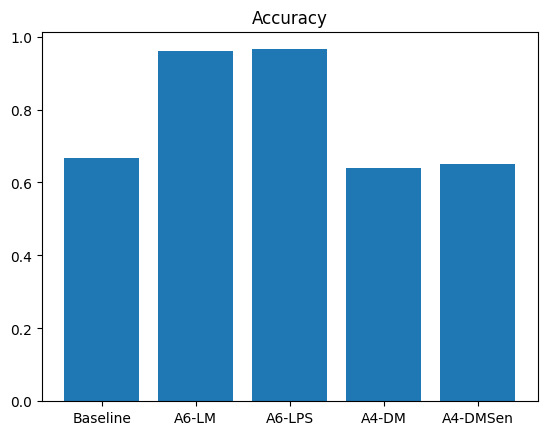

In [118]:
# Accuracy
plt.bar(np.arange(5),[acc_cons_bas,acc_cons_lm,acc_cons_lps,acc_cons_A41, acc_cons_A42])
plt.xticks(np.arange(5),['Baseline','A6-LM','A6-LPS','A4-DM','A4-DMSen'])
plt.title("Accuracy")

In [119]:
diff_base = 0.0199
diff_lm = 0.01059
diff_lps = 0.03958
diff_A41 = 0.000940	
diff_A42 = 0.014716

Text(0.5, 1.0, 'Absolute Calibration')

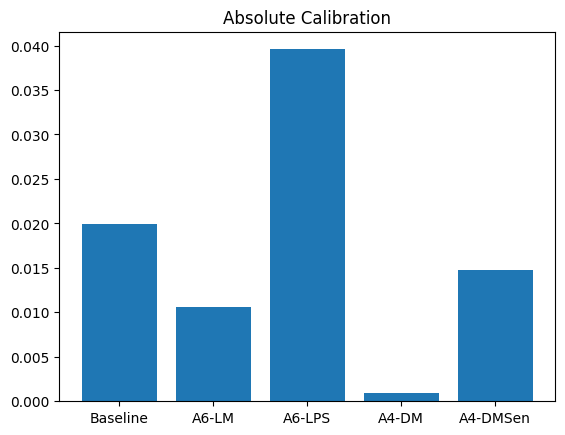

In [120]:
#  Callibration
plt.bar(np.arange(5),[diff_base, diff_lm, diff_lps, diff_A41, diff_A42])
plt.xticks(np.arange(5),['Baseline','A6-LM','A6-LPS','A4-DM','A4-DMSen'])
plt.title("Absolute Calibration")  

In [121]:
f1_base= 0.62446
f1_lm = 0.96461
f1_lps = 0.96733
f1_A41 =  0.7285619215058643
f1_A42 = 0.7123953779218256

Text(0.5, 1.0, 'F1-score')

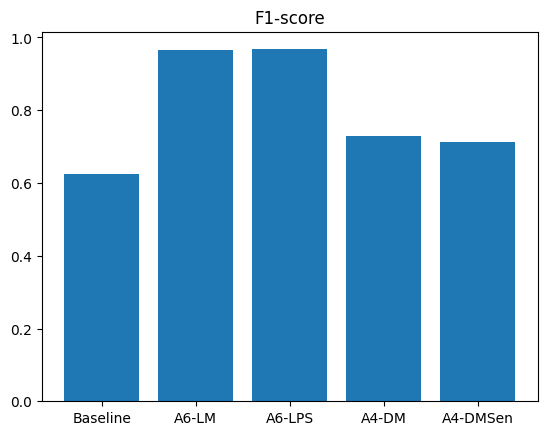

In [122]:
#  F1
plt.bar(np.arange(5),[f1_base, f1_lm, f1_lps, f1_A41,f1_A42 ])
plt.xticks(np.arange(5),['Baseline','A6-LM','A6-LPS','A4-DM','A4-DMSen'])
plt.title("F1-score")

In [123]:
recall_base= 0.57816
recall_lm = 0.97363
recall_lps = 0.95658
recall_A41 = 0.713043
recall_A42 = 0.6811590000000001 

Text(0.5, 1.0, 'Recall-score')

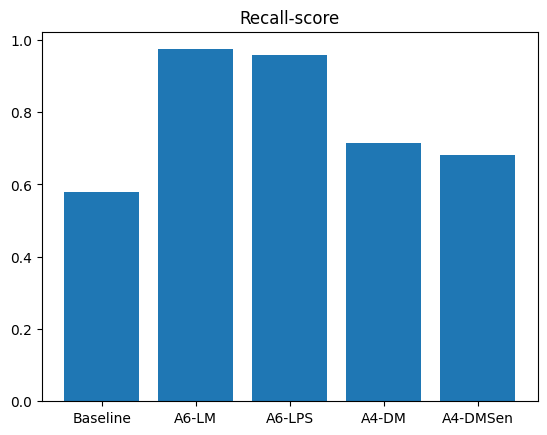

In [124]:
# Recall 
plt.bar(np.arange(5),[recall_base,recall_lm,recall_lps,recall_A41,recall_A42])
plt.xticks(np.arange(5),['Baseline','A6-LM','A6-LPS','A4-DM','A4-DMSen'])
plt.title("Recall-score")

###Conclusion

Recall measures the ability of the model to correctly identify positive instances, while F1 score is a summary metric that takes into account both precision and recall to provide an overall measure of the model's performance.

We plotted accuracy, absolute calibration, F1, and recall for all five models as above.

- 1) LM and LPS have the similar highest accuracy while baseline and DM-sen have the similar lowest accuracy;
- 2) LM has the lowest caliberation while LPS has the highest caliberation;
- 3) LM and LPS have the similar highest F1-score;
- 4) LM has the highest recall-score.

In summary, the overall performance of A6 is better than A4. For accuracy, F1, and recall, A6-LM and A6-LPS are almost equally competitive in removing bias of sensitive attribute like race. According to calibration, A6-LM performs better than A6-LPS because of relabel algorithm.